In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils
import torch.utils.data
import torch.optim as optim

from copy import deepcopy

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [2]:
# Make sure that we are utilizing a DL accelerator
DEVICE_CPU = torch.device("cpu")
DEVICE_GPU = torch.device("cuda")

device = DEVICE_GPU if torch.cuda.is_available() else DEVICE_CPU
print(device)

cuda


Files already downloaded and verified


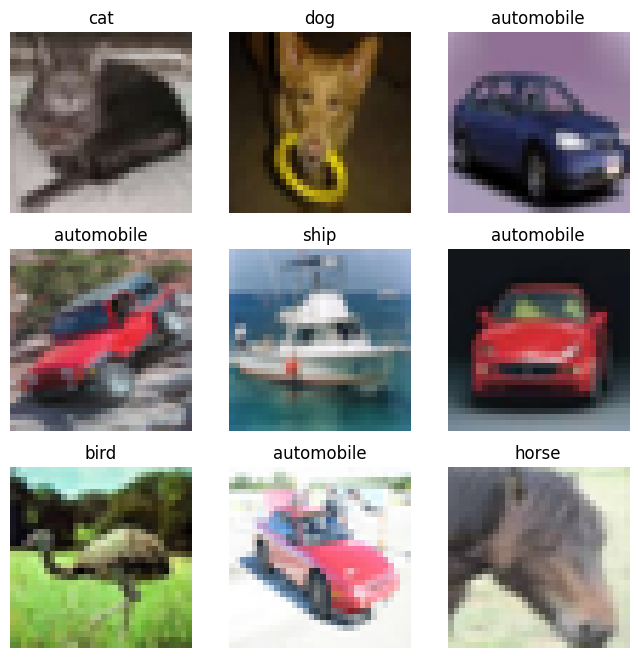

In [3]:
# Load CIFAR-10 dataset
train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
train_set, valid_set = torch.utils.data.random_split(train_set, [0.9, 0.1])

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

# Plot some images with labels
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
plt.show()

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

# Define model
# TODO: Check how the initialization is handled in Pytorch


class ConvGroup(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, pool=False):
        super().__init__()

        layers = [
            nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
        ]

        if pool:
            layers.append(nn.MaxPool2d(kernel_size=2))

        self.conv_group = nn.Sequential(*layers)

    def forward(self, X: Tensor):
        return self.conv_group(X)


class ResNet9(nn.Module):
    def __init__(self, p=0.3):
        super().__init__()

        self.conv_group1 = ConvGroup(3, 64, pool=False)
        self.conv_group2 = ConvGroup(64, 128, pool=True)
        self.conv_group3 = ConvGroup(128, 256, pool=True)
        self.conv_group4 = ConvGroup(256, 512, pool=True)

        self.res1 = nn.Sequential(ConvGroup(128, 128), ConvGroup(128, 128))
        self.res2 = nn.Sequential(ConvGroup(512, 512), ConvGroup(512, 512))

        self.dropout1 = nn.Dropout(p)
        self.dropout2 = nn.Dropout(p)

        self.clf = nn.Sequential(
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=10),
        )

    def forward(self, X: Tensor):
        y = X

        y = self.conv_group1(y)
        y = self.conv_group2(y)
        y = y + self.res1(y)

        y = self.conv_group3(y)
        y = self.conv_group4(y)
        y = y + self.res2(y)

        y = self.dropout2(y)

        y = self.clf(y)

        return y


class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)

        self.avgpool1 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.avgpool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=5 * 5 * 16, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, X):
        X = F.relu(self.avgpool1(self.conv1(X)))
        X = F.relu(self.avgpool2(self.conv2(X)))

        X = torch.flatten(X, 1)
        X = self.mlp(X)
        return X

In [5]:
from tqdm import trange


def train_model(
    model: nn.Module,
    optimizer,
    criterion,
    dataloaders: dict[str, DataLoader],
    n_epochs: int,
    verbose=False,
    device=DEVICE_GPU,
):
    model.to(device)

    best_acc, best_model_wts = 0.0, deepcopy(model.state_dict())

    for epoch in (pbar := trange(1, n_epochs + 1)):
        print(f"Epoch {epoch:4.0f}/{n_epochs}") if verbose else ...

        for phase in ["train", "valid"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print(f"{phase.upper()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}") if verbose else ...

            # deep copy the model
            if phase == "valid" and epoch_acc > best_acc:
                best_acc, best_model_wts = epoch_acc, deepcopy(model.state_dict())

        pbar.set_description(f"Best valid acc {best_acc*100:.2f}%")
        print() if verbose else ...

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model


@torch.no_grad()
def eval_model(model: nn.Module, dataloader: DataLoader, device=DEVICE_GPU):
    model.to(device)
    model.eval()

    corrects = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        corrects += torch.sum(preds == labels.data)

    test_acc = corrects / len(dataloader.dataset)
    # print(f"Test Acc: {test_acc:.4f}")
    return test_acc

In [6]:
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

import optuna


def objective(trial: optuna.trial.BaseTrial):
    print(f"Trial: {trial.number}")
    print("-" * 10)

    # Suggest values for hyperparameters
    p = trial.suggest_float("p", 0.0, 1.0)
    lr = trial.suggest_float("lr", 1e-5, 1e-3)
    n_epochs = trial.suggest_int("n_epochs", 10, 60)
    batch_size = trial.suggest_int("batch_size", 32, 512)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-1)

    # Define data loaders
    dataloaders = {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "valid": DataLoader(valid_set, batch_size=batch_size, shuffle=True),
    }

    # Define model, loss function and optimizer
    model = ResNet9(p=p)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train model
    train_model(model, optimizer, criterion, dataloaders, n_epochs)

    # Evaluate model performance on test set
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    return eval_model(model, test_dataloader)


study = optuna.create_study(study_name="Hyperparameter search")
study.optimize(objective, n_trials=12)

Files already downloaded and verified


[I 2024-10-27 18:38:15,287] A new study created in memory with name: Hyperparameter search


Trial: 0
----------


Best valid acc 72.36%:   5%|▌         | 3/60 [01:24<26:52, 28.29s/it]
[W 2024-10-27 18:39:40,302] Trial 0 failed with parameters: {'p': 0.09454745639076956, 'lr': 0.00036242347806347174, 'n_epochs': 60, 'batch_size': 327, 'weight_decay': 0.03010405041856835} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/barto/fun/image-recognition-lab/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_62640/2197860563.py", line 29, in objective
    train_model(model, optimizer, criterion, dataloaders, n_epochs)
  File "/tmp/ipykernel_62640/3281908362.py", line 54, in train_model
    running_loss += loss.item() * inputs.size(0)
KeyboardInterrupt
[W 2024-10-27 18:39:40,303] Trial 0 failed with value None.


KeyboardInterrupt: 